<a href="https://colab.research.google.com/github/priyarajmohan/ML_projects/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
data = tfds.load('fashion_mnist', split='train')

In [ ]:
data

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
data.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [ ]:
data.as_numpy_iterator().next()['label']

2

In [ ]:
data.as_numpy_iterator().next()['image']

In [ ]:
import numpy as np
DI = data.as_numpy_iterator()

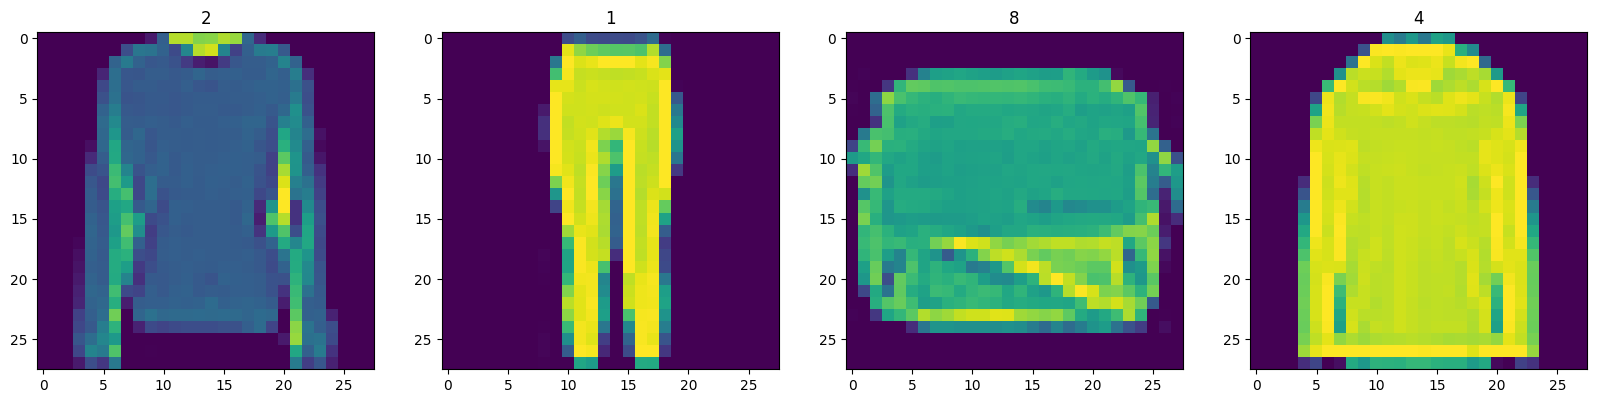

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
  sample = DI.next()
  ax[i].imshow(np.squeeze(sample['image']))
  ax[i].title.set_text(sample['label'])

In [ ]:
def image_scaling(data):
  image = data['image']
  return image / 255

In [ ]:
data = tfds.load('fashion_mnist', split='train')
data = data.map(image_scaling)
data = data.cache()
data = data.shuffle(60000)
data = data.batch(128)
data = data.prefetch (64)

In [ ]:
data.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [ ]:
def generator():
  model = Sequential()
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Conv2D(1, 4,padding='same', activation='sigmoid'))
  return model

In [ ]:
generator = generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [ ]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 2s 2s/step


(4, 28, 28, 1)

1/1 [==============================] - 0s 20ms/step


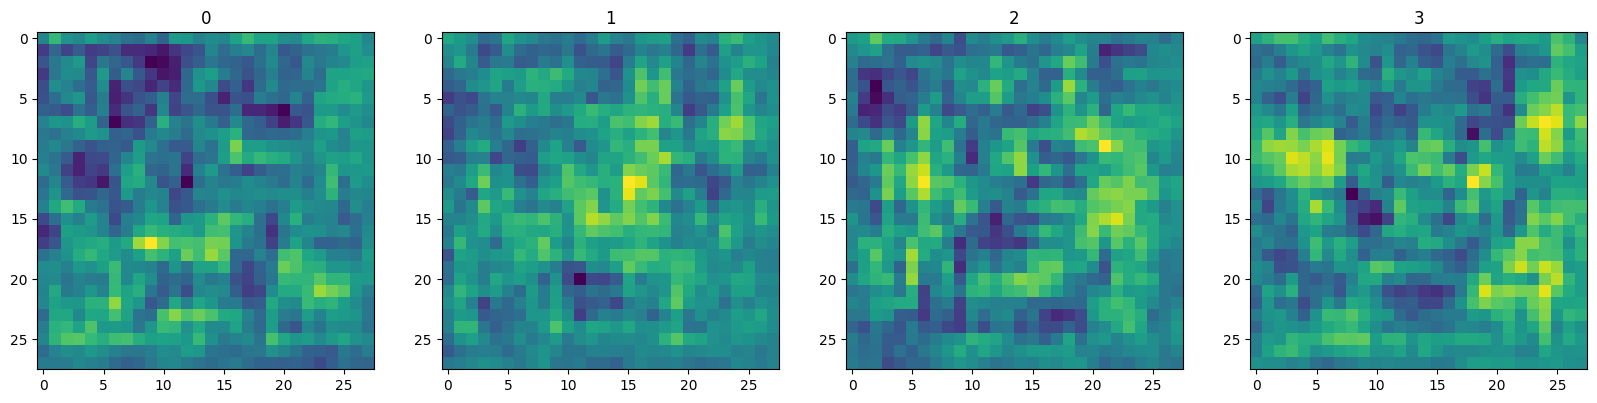

In [ ]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(img):
  ax[i].imshow(np.squeeze(img))
  ax[i].title.set_text(i)

In [ ]:
def discriminator():
  model = Sequential ()
  model.add(Conv2D (32, 5, input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D (64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D (128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D (256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dropout (0.4))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
discriminator = discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img = img[0]

In [ ]:
img.shape

(28, 1)

In [ ]:
#discriminator.predict(img)

In [ ]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
import tensorflow as tf
from keras.models import Model

In [ ]:
class GAN_Generation(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            predicted_labels = self.discriminator(gen_images, training=False)

            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
fashgan = GAN_Generation(generator, discriminator)

In [ ]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
data.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [ ]:
history = fashgan.fit(data, epochs=100)

Epoch 1/100
469/469 [==============================] - 89s 179ms/step - d_loss: 0.5802 - g_loss: 0.8940
Epoch 2/100
469/469 [==============================] - 83s 177ms/step - d_loss: 0.3469 - g_loss: 1.7909
Epoch 3/100
469/469 [==============================] - 83s 177ms/step - d_loss: 0.3241 - g_loss: 5.9086
Epoch 4/100
469/469 [==============================] - 83s 177ms/step - d_loss: 0.4761 - g_loss: 1.6685
Epoch 5/100
469/469 [==============================] - 84s 178ms/step - d_loss: 0.5899 - g_loss: 0.4100
Epoch 6/100
469/469 [==============================] - 83s 178ms/step - d_loss: 0.3706 - g_loss: 0.0493
Epoch 7/100
469/469 [==============================] - 83s 178ms/step - d_loss: 0.3263 - g_loss: 0.0215
Epoch 8/100
469/469 [==============================] - 83s 178ms/step - d_loss: 0.3149 - g_loss: 0.0234
Epoch 9/100
469/469 [==============================] - 83s 177ms/step - d_loss: 0.3058 - g_loss: 0.0253
Epoch 10/100
469/469 [==============================] - 83s 177m

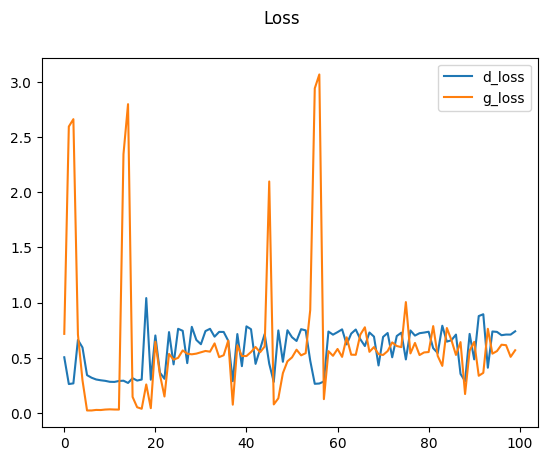

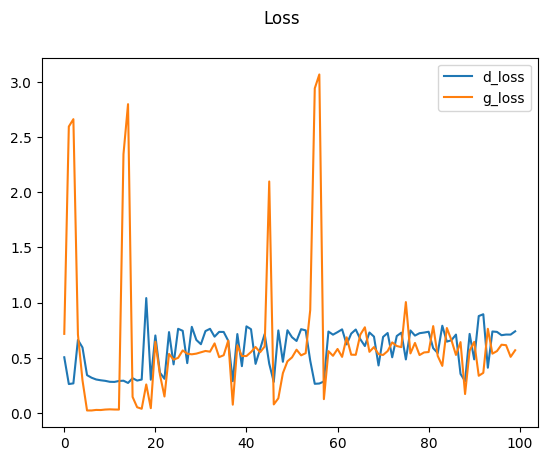

In [ ]:
plt.suptitle('Loss')
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

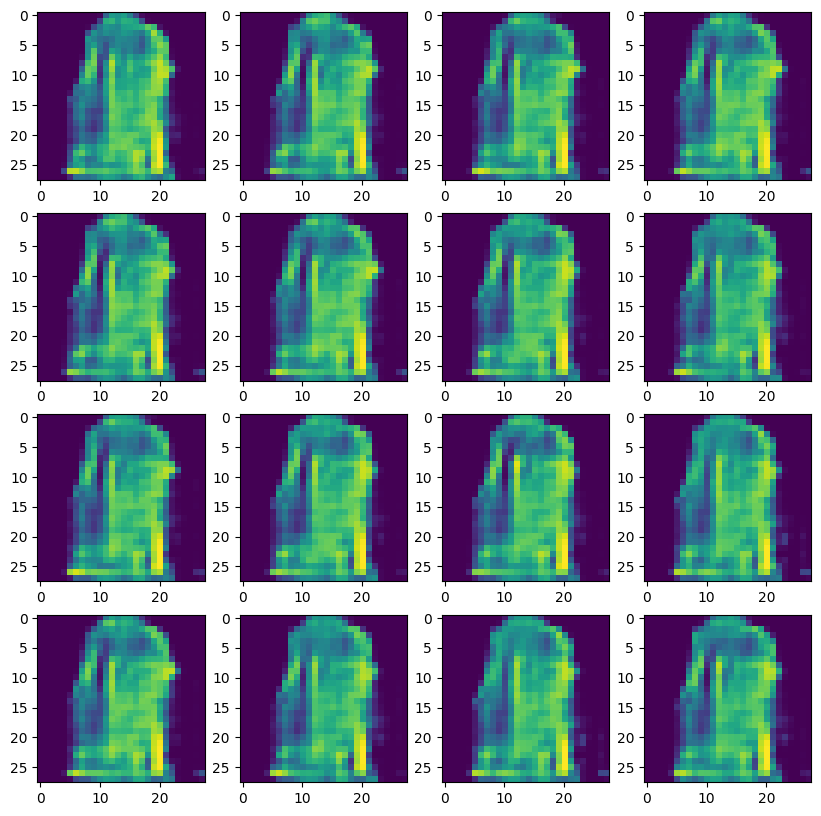

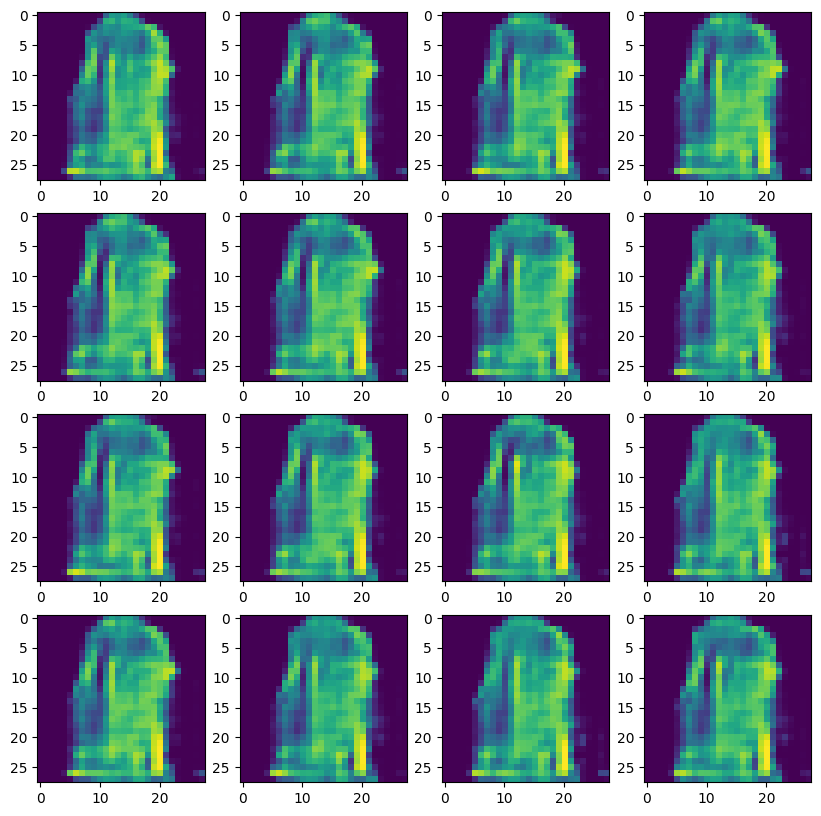

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])